# Atividade: CNNs para Classificação

Neste notebook, iremos preparar nosso próprio dataset e treinar um modelo de classificação de imagens.

## Preparando os dados

Os dados desta atividade serão baixados da internet. Utilizaremos para isso buscadores comuns. Em seguida, dividiremos em treinamento e validação.

In [77]:
%pip install icrawler --quiet
%pip install pyimagedl --quiet
%pip install seaborn --quiet



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [78]:



import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import shutil
import random
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def set_seed(seed=42):
    """Congela a aleatoriedade para tornar o experimento reprodutível."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # Se usar multi-GPU

    # Garante comportamento determinístico no CuDNN (pode deixar um pouco mais lento)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Configuração de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [79]:
import random
#from icrawler.builtin import GoogleImageCrawler, BingImageCrawler

#from google.colab import drive
#drive.mount('/content/drive')


### Adquirindo as Imagens

Utilizaremos o iCrawler para baixar imagens em buscadores através de termos especificados. Defina sua lista de classes.

In [80]:
from imagedl import imagedl

def download_images_generic(keyword, label, output_dir="data", target_total=100):
    final_folder = os.path.join(output_dir, label)
    os.makedirs(final_folder, exist_ok=True)

    # Conta imagens já existentes
    count_existing = len([
        f for f in os.listdir(final_folder)
        if f.lower().endswith(('.jpg', '.png', '.jpeg', '.webp'))
    ])

    if count_existing >= target_total:
        print(f"✅ [{label}] Já possui {count_existing} imagens. Pulando...")
        return

    needed = target_total - count_existing
    print(f"⬇️ [{label}] Possui {count_existing}. Baixando mais {needed} imagens...")

    temp_folder = final_folder + "_tmp"
    if os.path.exists(temp_folder):
        shutil.rmtree(temp_folder)

    try:
        # Configuração do cliente
        client = imagedl.ImageClient(
            image_source='GoogleImageClient',
            init_image_client_cfg={'work_dir': temp_folder},
            # Baixamos um pouco a mais para garantir caso alguns falhem
            search_limits=needed + 30,
            num_threadings=4,
        )

        # Busca e download
        image_infos = client.search(keyword, search_limits_overrides=needed + 30)
        client.download(image_infos=image_infos)

        moved = 0
        new_count = count_existing

        # Move e renomeia as imagens do temp para a pasta final
        for root, dirs, files in os.walk(temp_folder):
            for file in files:
                if moved >= needed:
                    break

                if file.lower().endswith(('.jpg', '.jpeg', '.png', '.webp')):
                    src = os.path.join(root, file)
                    # Formato: mondstadt_0001.jpg, liyue_0050.jpg, etc.
                    dst = os.path.join(final_folder, f"{label}_{new_count:04d}.jpg")
                    try:
                        shutil.move(src, dst)
                        moved += 1
                        new_count += 1
                    except:
                        pass

        print(f"Concluído! Agora [{label}] tem {new_count} imagens.")

    except Exception as e:
        print(f"Erro ao baixar imagens para {label}: {e}")
    finally:
        if os.path.exists(temp_folder):
            shutil.rmtree(temp_folder)

In [81]:
# -------------------------------------------------------------
# CONFIGURAÇÃO PARA O PROJETO GENSHIN
# -------------------------------------------------------------
OUTPUT_DIR = "/content/drive/MyDrive/genshin_landscape_dataset"

# Estratégia: Definimos as sub-regiões visuais distintas aqui.
# O modelo vai aprender "Enkanomiya", "Dragonspine", etc.
classes = {
    # MONDTADT
    "mondstadt": "genshin impact mondstadt landscape scenery -character -build",
    "dragonspine": "genshin impact dragonspine landscape scenery snow -character",

    # LIYUE
    "liyue": "genshin impact liyue  landscape scenery -character",
    "the_chasm": "genshin impact the chasm underground landscape -character",

    # INAZUMA
    "inazuma": "genshin impact inazuma landscape scenery -character",
    "enkanomiya": "genshin impact enkanomiya landscape scenery -character",

    # SUMERU
    "sumeru": "genshin impact sumeru landscape -character",
    "sumeru_desert": "genshin impact sumeru desert landscape -character",

    # FONTAINE
    "fontaine": "genshin impact fontaine  landscape scenery -character",
    "fontaine_underwater": "genshin impact fontaine underwater scenery -character"
}

TARGET_IMAGES = 150 

# Loop de execução
print("--- Iniciando Download dos Cenários de Genshin Impact ---")
#for label, keyword in classes.items():
#    download_images_generic(keyword, label, output_dir=OUTPUT_DIR, target_total=TARGET_IMAGES)

print("\nProcesso finalizado!")

--- Iniciando Download dos Cenários de Genshin Impact ---

Processo finalizado!


# Carregando imagens do drive

### Treinamento e Validação

Dividiremos as imagens baixadas nas pastas `train` e `val`. Defina uma porcentagem.

In [82]:
def split_train_val(root_dir, train_ratio=0.8, seed=42):
    random.seed(seed)

    train_dir = root_dir + "_split/train"
    val_dir = root_dir + "_split/val"

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [os.path.join(class_path, f) for f in os.listdir(class_path)]
        images = [f for f in images if os.path.isfile(f)]
        random.shuffle(images)

        n_train = int(len(images) * train_ratio)

        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)

        for img in images[:n_train]:
            shutil.copy(img, os.path.join(train_class_dir, os.path.basename(img)))
        for img in images[n_train:]:
            shutil.copy(img, os.path.join(val_class_dir, os.path.basename(img)))

        print(f"{class_name}: {n_train} train, {len(images)-n_train} val")

In [83]:
def split_dataset_3way(root_dir, train_ratio=0.7, val_ratio=0.15, seed=42):
    split_root = root_dir + "_split"
    train_dir = os.path.join(split_root, "train")
    val_dir   = os.path.join(split_root, "val")
    test_dir  = os.path.join(split_root, "test")

    # SE JÁ EXISTE, NÃO FAZ NADA (Segurança)
    if os.path.exists(split_root) and len(os.listdir(split_root)) > 0:
        print(f"Dataset já dividido em: {split_root}")
        return train_dir, val_dir, test_dir

    print("Iniciando divisão do dataset...")
    for dir_path in [train_dir, val_dir, test_dir]:
        os.makedirs(dir_path, exist_ok=True)

    random.seed(seed)
    # Lista classes ordenadas para garantir consistência
    classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])

    for class_name in classes:
        src_path = os.path.join(root_dir, class_name)
        images = sorted([f for f in os.listdir(src_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        random.shuffle(images)

        n_total = len(images)
        n_train = int(n_total * train_ratio)
        n_val   = int(n_total * val_ratio)

        # Criar subpastas
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Copiar arquivos
        for img in images[:n_train]:
            shutil.copy(os.path.join(src_path, img), os.path.join(train_dir, class_name, img))
        for img in images[n_train : n_train + n_val]:
            shutil.copy(os.path.join(src_path, img), os.path.join(val_dir, class_name, img))
        for img in images[n_train + n_val:]:
            shutil.copy(os.path.join(src_path, img), os.path.join(test_dir, class_name, img))

        print(f"  [{class_name}] {n_train} Train, {n_val} Val, {n_total - n_train - n_val} Test")

    return train_dir, val_dir, test_dir

In [84]:
#TRAIN_DIR, VAL_DIR, TEST_DIR = split_dataset_3way(OUTPUT_DIR)

In [85]:
import os
import shutil
import random

# ==============================================================================
# 1. CONFIGURAÇÃO
# ==============================================================================
# Caminho da pasta que você subiu (arrastou para a esquerda no Colab)
# Certifique-se que o nome da pasta na barra lateral é exatamente este:
SOURCE_PATH = "genshin_landscape_dataset"

# Onde vamos salvar a versão organizada (treino/teste)
SPLIT_ROOT = "dataset_split_final"

# ==============================================================================
# 2. FUNÇÃO DE DIVISÃO (Caso a pasta venha "crua")
# ==============================================================================
def split_dataset_local(root_dir, target_root, train_ratio=0.7, val_ratio=0.15):
    # Cria pastas de destino
    for x in ['train', 'val', 'test']:
        os.makedirs(os.path.join(target_root, x), exist_ok=True)

    # Lista as classes (pastas dentro do dataset)
    classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    
    if not classes:
        print(f"❌ ERRO: Nenhuma pasta de classe encontrada dentro de {root_dir}")
        return

    print(f"🔄 Iniciando divisão do dataset...")
    
    for class_name in classes:
        class_dir = os.path.join(root_dir, class_name)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg', '.webp'))]
        
        # Embaralha para garantir aleatoriedade
        random.shuffle(images)
        
        # Calcula quantidades
        n_total = len(images)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)
        
        # Define splits
        splits = {
            'train': images[:n_train],
            'val':   images[n_train:n_train+n_val],
            'test':  images[n_train+n_val:]
        }
        
        # Copia os arquivos
        for split_name, split_imgs in splits.items():
            dest_dir = os.path.join(target_root, split_name, class_name)
            os.makedirs(dest_dir, exist_ok=True)
            for img in split_imgs:
                shutil.copy(os.path.join(class_dir, img), os.path.join(dest_dir, img))
                
        print(f"  [{class_name}] Total: {n_total} -> Train: {len(splits['train'])} | Val: {len(splits['val'])} | Test: {len(splits['test'])}")

# ==============================================================================
# 3. LÓGICA PRINCIPAL
# ==============================================================================

if not os.path.exists(SOURCE_PATH):
    print(f"❌ A pasta '{SOURCE_PATH}' não foi encontrada!")
    print("👉 Verifique se você arrastou a pasta para a aba de arquivos à esquerda e se o nome está correto.")
else:
    # Verifica se a pasta já tem 'train' e 'val' dentro (se já veio pronta)
    contents = os.listdir(SOURCE_PATH)
    if 'train' in contents and 'val' in contents:
        print("✅ Estrutura pronta detectada (pastas train/val já existem).")
        TRAIN_DIR = os.path.join(SOURCE_PATH, 'train')
        VAL_DIR = os.path.join(SOURCE_PATH, 'val')
        TEST_DIR = os.path.join(SOURCE_PATH, 'test') if 'test' in contents else VAL_DIR
    else:
        print("⚠️ Estrutura 'crua' detectada. Realizando divisão automática...")
        # Limpa destino anterior se existir
        if os.path.exists(SPLIT_ROOT): shutil.rmtree(SPLIT_ROOT)
        
        # Executa a divisão
        split_dataset_local(SOURCE_PATH, SPLIT_ROOT)
        
        TRAIN_DIR = os.path.join(SPLIT_ROOT, 'train')
        VAL_DIR = os.path.join(SPLIT_ROOT, 'val')
        TEST_DIR = os.path.join(SPLIT_ROOT, 'test')

    # Confirmação final
    print("\n--- Caminhos Configurados ---")
    print(f"Train: {TRAIN_DIR}")
    print(f"Val:   {VAL_DIR}")
    print(f"Test:  {TEST_DIR}")

⚠️ Estrutura 'crua' detectada. Realizando divisão automática...
🔄 Iniciando divisão do dataset...
  [dragonspine] Total: 53 -> Train: 37 | Val: 7 | Test: 9
  [enkanomiya] Total: 59 -> Train: 41 | Val: 8 | Test: 10
  [fontaine] Total: 234 -> Train: 163 | Val: 35 | Test: 36
  [fontaine_underwater] Total: 110 -> Train: 77 | Val: 16 | Test: 17
  [inazuma] Total: 211 -> Train: 147 | Val: 31 | Test: 33
  [liyue] Total: 208 -> Train: 145 | Val: 31 | Test: 32
  [mondstadt] Total: 157 -> Train: 109 | Val: 23 | Test: 25
  [sumeru] Total: 164 -> Train: 114 | Val: 24 | Test: 26
  [sumeru_desert] Total: 136 -> Train: 95 | Val: 20 | Test: 21

--- Caminhos Configurados ---
Train: dataset_split_final\train
Val:   dataset_split_final\val
Test:  dataset_split_final\test


## Dataset

Implemente um Dataset PyTorch que carregue as imagens baixadas com suas respectivas classes. Aplique data augmentation e carregue em batches.

In [86]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [87]:
# Augmentation para TREINO (Variações para aprender melhor)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Zoom aleatório
    transforms.RandomHorizontalFlip(p=0.5),              # Espelhamento Horizontal
    transforms.RandomRotation(degrees=15),               # Rotação leve
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02), # Hue baixo!
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Para VALIDAÇÃO e TESTE (Apenas redimensionar e normalizar)
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset   = datasets.ImageFolder(VAL_DIR,   transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(TEST_DIR,  transform=val_test_transforms)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Classes: {train_dataset.classes}")
print("Total treino:", len(train_dataset))
print("Total validação:", len(val_dataset))

images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)
print("Labels:", labels[:10])



Classes: ['dragonspine', 'enkanomiya', 'fontaine', 'fontaine_underwater', 'inazuma', 'liyue', 'mondstadt', 'sumeru', 'sumeru_desert']
Total treino: 928
Total validação: 195
Batch shape: torch.Size([32, 3, 224, 224])
Labels: tensor([6, 5, 8, 5, 7, 2, 2, 4, 1, 5])


In [88]:
#from google.colab import drive
#drive.mount('/content/drive')

## Definição do Modelo

Defina aqui o modelo que será utilizado, sendo implementação própria ou um modelo pré-treinado. Teste diversas arquiteturas diferentes e verifique qual delas tem melhor desempenho em validação.

In [89]:
import torchvision.models as models
import torch.nn as nn # Adicionar esta linha para importar o módulo nn

NUM_CLASSES = 10


# ----------------------------------------------------------
# B — MobileNetV2 (transfer learning — rápido e eficiente)
# ----------------------------------------------------------
def build_mobilenet(num_classes):
    model = models.mobilenet_v2(weights="IMAGENET1K_V1")

    for param in model.features.parameters():
      param.requires_grad = False

    model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    return model


# ----------------------------------------------------------
# C — ResNet-50 (alto desempenho)
# ----------------------------------------------------------
def build_resnet50(num_classes=3):
    model = models.resnet50(weights="IMAGENET1K_V2")
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# ----------------------------------------------------------
# D — EfficientNet-B0 (ótima acurácia com baixo custo)
# ----------------------------------------------------------
def build_efficientnet(num_classes, dropout_rate=0.2):
    model = models.efficientnet_b0(weights="IMAGENET1K_V1")
    
    for param in model.features[-3:].parameters():
        param.requires_grad = True
        
    model.classifier[0] = nn.Dropout(p=dropout_rate, inplace=True)
    
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

# ----------------------------------------------------------
# Função auxiliar para escolher o modelo
# ----------------------------------------------------------
def get_model(name, num_classes, dropout_rate=0.2):
    name = name.lower()
    if name == "mobilenet":
        return build_mobilenet(num_classes)
    elif name == "efficientnet":
        return build_efficientnet(num_classes, dropout_rate)
    else:
        raise ValueError("Model name inválido.")

## Treinamento

Defina a função de custo e o otimizador do modelo. Em seguida, implemente o código de treinamento e treine-o. Ao final, exiba as curvas de treinamento e validação para a loss e a acurácia.

In [90]:

import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim # Adicionar esta linha para importar o otimizador

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------------
# Função de treino + validação
# ---------------------------------------------------------

def train_model(model, train_loader, val_loader, epochs=10, lr=1e-4, save_name="best_model.pth"):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    best_val_acc = 0.0
    best_state = None

    for epoch in range(epochs):
        print(f"\nEPOCH {epoch+1}/{epochs}")
        model.train()

        epoch_loss = 0
        correct = 0
        total = 0

        # -------------------- TREINO --------------------
        pbar = tqdm(train_loader, desc="Training", leave=False)
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss = epoch_loss / len(train_loader)

        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # -------------------- VALIDAÇÃO --------------------
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)

                outputs = model(imgs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        val_loss = val_loss / len(val_loader)

        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

        # ---------------- Salvar melhor modelo ----------------
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()

    # salvar checkpoint final
    if best_state is not None:
      torch.save(best_state, save_name)
      print(f"\nMelhor modelo salvo em '{save_name}' com Val Acc = {best_val_acc:.4f}")
    else:
      print("\nO modelo não melhorou em nenhuma época")

    return train_losses, val_losses, train_accs, val_accs


# ---------------------------------------------------------
# Função para plotar curvas
# ---------------------------------------------------------

def plot_curves(train_losses, val_losses, train_accs, val_accs):

    plt.figure(figsize=(12,5))

    # LOSS
    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Curva de Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # ACURÁCIA
    plt.subplot(1,2,2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.title("Curva de Acurácia")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

In [91]:
def train_and_evaluate(model_name, model, train_loader, val_loader, epochs=8, lr=1e-4):

    print(f"\n==============================")
    print(f" Treinando modelo: {model_name}")
    print(f"==============================")

    filename = f"best_model_{model_name}.pth"

    train_losses, val_losses, train_accs, val_accs = train_model(
        model,
        train_loader,
        val_loader,
        epochs=epochs,
        lr=lr,
        save_name=filename
    )

    best_val_acc = max(val_accs)

    return {
        "name": model_name,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "best_val_acc": best_val_acc
    }


In [92]:
models_to_test = {
    #"SimpleCNN": get_model("cnn"),
    #"MobileNetV2": get_model("mobilenet", num_classes=len(train_dataset.classes))
    #"ResNet50": get_model("resnet50")
    "EfficientNet": get_model("efficientnet", num_classes=len(train_dataset.classes), dropout_rate=0.4)
}


In [93]:

results = []


for name, model in models_to_test.items():
    model = model.to(device)
    r = train_and_evaluate(name, model, train_loader,val_loader, epochs = 20, lr=1e-4)
    results.append(r)



 Treinando modelo: EfficientNet

EPOCH 1/20


Train Loss: 2.0663 | Train Acc: 0.2726
Val Loss:   1.8738 | Val Acc:   0.4308

EPOCH 2/20


Train Loss: 1.7160 | Train Acc: 0.5075
Val Loss:   1.5537 | Val Acc:   0.5385

EPOCH 3/20


Train Loss: 1.3809 | Train Acc: 0.6218
Val Loss:   1.2374 | Val Acc:   0.6462

EPOCH 4/20


Train Loss: 1.0291 | Train Acc: 0.7640
Val Loss:   0.9432 | Val Acc:   0.7282

EPOCH 5/20


Train Loss: 0.7438 | Train Acc: 0.8330
Val Loss:   0.7746 | Val Acc:   0.7641

EPOCH 6/20


Train Loss: 0.5680 | Train Acc: 0.8664
Val Loss:   0.6714 | Val Acc:   0.8051

EPOCH 7/20


Train Loss: 0.4143 | Train Acc: 0.9127
Val Loss:   0.5807 | Val Acc:   0.8308

EPOCH 8/20


Train Loss: 0.3434 | Train Acc: 0.9343
Val Loss:   0.5367 | Val Acc:   0.8513

EPOCH 9/20


Train Loss: 0.2388 | Train Acc: 0.9569
Val Loss:   0.5170 | Val Acc:   0.8513

EPOCH 10/20


Train Loss: 0.1830 | Train Acc: 0.9698
Val Loss:   0.4730 | Val Acc:   0.8769

EPOCH 11/20


Train Loss: 0.1395 | Train Acc: 0.9720
Val Loss:   0.4258 | Val Acc:   0.8769

EPOCH 12/20


Train Loss: 0.1146 | Train Acc: 0.9774
Val Loss:   0.4125 | Val Acc:   0.8769

EPOCH 13/20


Train Loss: 0.1049 | Train Acc: 0.9806
Val Loss:   0.4192 | Val Acc:   0.8667

EPOCH 14/20


Train Loss: 0.0737 | Train Acc: 0.9892
Val Loss:   0.4364 | Val Acc:   0.8718

EPOCH 15/20


Train Loss: 0.0674 | Train Acc: 0.9881
Val Loss:   0.4274 | Val Acc:   0.8718

EPOCH 16/20


Train Loss: 0.0630 | Train Acc: 0.9871
Val Loss:   0.4378 | Val Acc:   0.8718

EPOCH 17/20


Train Loss: 0.0565 | Train Acc: 0.9871
Val Loss:   0.4315 | Val Acc:   0.8769

EPOCH 18/20


Train Loss: 0.0489 | Train Acc: 0.9946
Val Loss:   0.4081 | Val Acc:   0.8718

EPOCH 19/20


Train Loss: 0.0493 | Train Acc: 0.9903
Val Loss:   0.4447 | Val Acc:   0.8718

EPOCH 20/20


Train Loss: 0.0415 | Train Acc: 0.9892
Val Loss:   0.4174 | Val Acc:   0.8923

Melhor modelo salvo em 'best_model_EfficientNet.pth' com Val Acc = 0.8923


In [94]:
print("\n===== RESULTADO FINAL =====\n")
for r in results:
    print(f"{r['name']:20s}  |  Best Val Acc: {r['best_val_acc']:.4f}")



===== RESULTADO FINAL =====

EfficientNet          |  Best Val Acc: 0.8923


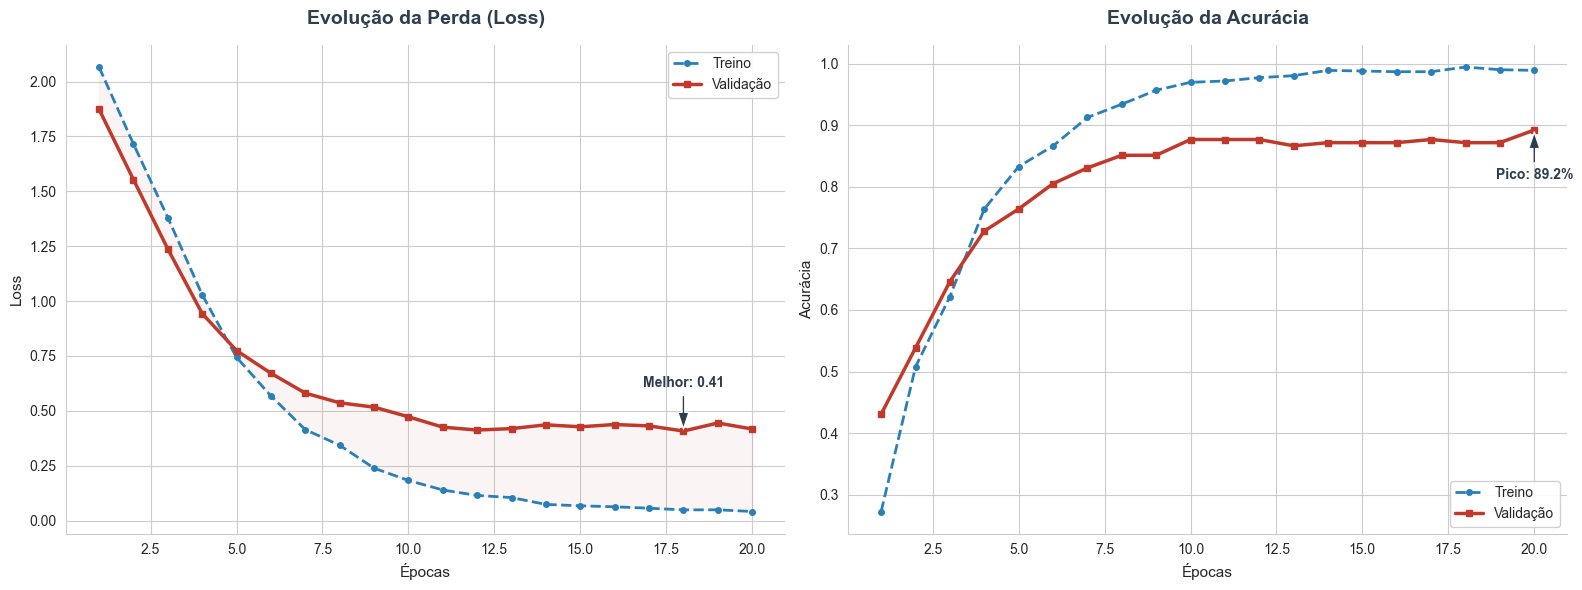

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_comparison(results):
# Define o estilo visual "Clean"
    sns.set_style("whitegrid")
    
    # Cores Profissionais
    c_train = '#2980b9' # Azul Belize
    c_val   = '#c0392b' # Vermelho Pomegranate
    c_text  = '#2c3e50' # Cinza Escuro (quase preto)
    
    for res in results:
        train_loss = res['train_losses']
        val_loss = res['val_losses']
        train_acc = res['train_accs']
        val_acc = res['val_accs']
        epochs = range(1, len(train_loss) + 1)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # --- GRÁFICO 1: LOSS ---
        # Área de divergência (sombra leve onde Validação > Treino)
        ax1.fill_between(epochs, train_loss, val_loss, color=c_val, alpha=0.05)
        
        ax1.plot(epochs, train_loss, color=c_train, linestyle='--', linewidth=2, label='Treino', marker='o', markersize=4)
        ax1.plot(epochs, val_loss, color=c_val, linewidth=2.5, label='Validação', marker='s', markersize=4)
        
        ax1.set_title("Evolução da Perda (Loss)", fontsize=14, fontweight='bold', color=c_text, pad=15)
        ax1.set_xlabel("Épocas", fontsize=11)
        ax1.set_ylabel("Loss", fontsize=11)
        ax1.legend(frameon=True, facecolor='white', framealpha=0.9, loc='upper right')
        
        # Remove bordas desnecessárias (topo e direita)
        sns.despine(ax=ax1)

        # Seta indicando o MELHOR momento (Menor Loss)
        min_loss = min(val_loss)
        best_epoch_loss = val_loss.index(min_loss) + 1
        ax1.annotate(f'Melhor: {min_loss:.2f}', xy=(best_epoch_loss, min_loss), xytext=(best_epoch_loss, min_loss + 0.2),
                     arrowprops=dict(facecolor=c_text, shrink=0.05, width=2, headwidth=8), 
                     color=c_text, ha='center', fontweight='bold')

        # --- GRÁFICO 2: ACCURACY ---
        ax2.plot(epochs, train_acc, color=c_train, linestyle='--', linewidth=2, label='Treino', marker='o', markersize=4)
        ax2.plot(epochs, val_acc, color=c_val, linewidth=2.5, label='Validação', marker='s', markersize=4)
        
        ax2.set_title("Evolução da Acurácia", fontsize=14, fontweight='bold', color=c_text, pad=15)
        ax2.set_xlabel("Épocas", fontsize=11)
        ax2.set_ylabel("Acurácia", fontsize=11)
        ax2.legend(frameon=True, facecolor='white', framealpha=0.9, loc='lower right')
        
        sns.despine(ax=ax2)
        
        # Seta indicando o PICO de performance
        max_acc = max(val_acc)
        best_epoch_acc = val_acc.index(max_acc) + 1
        ax2.annotate(f'Pico: {max_acc*100:.1f}%', xy=(best_epoch_acc, max_acc), xytext=(best_epoch_acc, max_acc - 0.08),
                     arrowprops=dict(facecolor=c_text, shrink=0.05, width=2, headwidth=8), 
                     color=c_text, ha='center', fontweight='bold')

        plt.tight_layout()
        plt.show()
        
plot_comparison(results)


## Inferência

Calcule algumas métricas como acurácia, matriz de confusão, etc. Em seguida, teste o modelo em novas imagens das classes correspondentes mas de outras fontes (outro buscador, fotos próprias, etc).

In [96]:
# Mapeamento: Sub-região visual -> Nação
region_hierarchy = {
    "mondstadt": "Mondstadt", "dragonspine": "Mondstadt (Dragonspine)",
    "liyue": "Liyue",
    "inazuma": "Inazuma", "enkanomiya": "Inazuma (Enkanomiya)",
    "sumeru": "Sumeru", "sumeru_desert": "Sumeru (Deserto)",
    "fontaine": "Fontaine", "fontaine_underwater": "Fontaine (Debaixo d'água)"
}

In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import torch

def evaluate_complete(model, loader, class_names):
    # --- 1. Obter Predições ---
    model.eval()
    all_preds = []
    all_labels = []

    print("Calculando métricas no Test Set...")

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- Relatório em Texto  ---
    print("\n--- Relatório de Classificação ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # --- 2. Preparar Dados ---
    # Métricas
    report_dict = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report_dict).transpose()
    classes_df = df_report.drop(['accuracy', 'macro avg', 'weighted avg'])
    
    # Matriz
    cm = confusion_matrix(all_labels, all_preds)
    
    # Configuração de fonte
    TITLE_SIZE = 18    # Título principal
    LABEL_SIZE = 18    # Nomes das regiões e eixos
    ANNOT_SIZE = 18    # Números dentro do heatmap/barras
    
    # ==========================================
    # FIGURA 1: DASHBOARD DE MÉTRICAS (Heatmap + Barras)
    # ==========================================
    fig, axes = plt.subplots(1, 2, figsize=(16, 9), gridspec_kw={'width_ratios': [2, 1]})

    # --- Plot 1: Heatmap ---
    sns.heatmap(classes_df[['precision', 'recall', 'f1-score']], 
                annot=True, cmap='RdYlGn', fmt='.2f', vmin=0.7, vmax=1.0, 
                cbar=False, ax=axes[0], 
                annot_kws={'size': ANNOT_SIZE}) # <--- Aumenta números internos
    
    axes[0].set_title('Métricas por classe', fontsize=TITLE_SIZE, pad=15)
    
    # Aumentar fontes dos eixos
    axes[0].tick_params(axis='y', labelsize=LABEL_SIZE, rotation=0) # <--- Nomes das Regiões
    axes[0].tick_params(axis='x', labelsize=LABEL_SIZE)             # <--- Precision/Recall...

    # --- Plot 2: Barras de Support ---
    sns.barplot(x=classes_df['support'], y=classes_df.index, ax=axes[1], color='skyblue', edgecolor='black')
    
    axes[1].set_title('Qtd. Imagens (Support)', fontsize=TITLE_SIZE, pad=15)
    axes[1].set_ylabel('')
    axes[1].set_yticklabels([]) 
    axes[1].tick_params(axis='x', labelsize=LABEL_SIZE)
    axes[1].grid(axis='x', linestyle='--', alpha=0.6)

    # Números na ponta das barras
    for i, v in enumerate(classes_df['support']):
        axes[1].text(v + 0.5, i, f"{int(v)}", color='black', va='center', fontweight='bold', fontsize=ANNOT_SIZE)


    plt.tight_layout()
    plt.show()
    
    # ==========================================
    # FIGURA 2: MATRIZ DE CONFUSÃO 
    # ==========================================
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, 
                annot_kws={'size': ANNOT_SIZE})
    
    plt.title('Matriz de Confusão', fontsize=TITLE_SIZE, pad=20)
    plt.xlabel('Predito', fontsize=16)
    plt.ylabel('Real', fontsize=16)
    plt.xticks(rotation=90, fontsize=16)
    plt.yticks(rotation=0, fontsize=16)
    
    plt.tight_layout()
    plt.show() # Mostra o segundo gráfico

In [98]:
def visualize_grid(model, dataset, num_images=9, seed=None):
    model.eval()

    if seed is not None:
        g = torch.Generator()
        g.manual_seed(seed)
        indices = torch.randperm(len(dataset), generator=g)[:num_images].tolist()
    else:
        indices = random.sample(range(len(dataset)), num_images)

    plt.figure(figsize=(12, 12))

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        input_tensor = img.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            prob = torch.nn.functional.softmax(output, dim=1)
            conf, pred_idx = torch.max(prob, 1)

        pred_class = dataset.classes[pred_idx.item()]
        real_class = dataset.classes[label]

        # Mapear para Nação
        nation = region_hierarchy.get(pred_class, "")

        # Cor: Verde se acertou, Vermelho se errou
        color = 'green' if pred_class == real_class else 'red'

        # Desnormalizar para exibir (assumindo ImageNet stats)
        inv_norm = transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
        img_show = inv_norm(img).permute(1, 2, 0).cpu().numpy()
        img_show = np.clip(img_show, 0, 1)

        plt.subplot(3, 3, i + 1)
        plt.imshow(img_show)
        plt.axis('off')
        plt.title(f"Pred: {pred_class}\nReal: {real_class}\n{nation}\n{conf.item():.1%}",
                  color=color, fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

In [99]:
def visualize_uncertainty(model, dataset, num_images=5, seed=None):
    model.eval()

    # 1. Lógica de Sorteio (IGUAL AO GRID)
    if seed is not None:
        g = torch.Generator()
        g.manual_seed(seed)
        indices = torch.randperm(len(dataset), generator=g)[:num_images].tolist()
    else:
        indices = random.sample(range(len(dataset)), num_images)

    # Parâmetros de denormalização
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    print(f"--- Visualização de Incerteza (Amostras: {indices}) ---")

    for i, idx in enumerate(indices):
        # Pega a imagem direto do dataset pelo índice sorteado
        img_tensor, label = dataset[idx]

        # Prepara o batch de 1 imagem
        input_tensor = img_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(input_tensor)
            probs = torch.nn.functional.softmax(outputs, dim=1)

        # --- Plotagem ---
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Imagem
        img_show = img_tensor.cpu().numpy().transpose((1, 2, 0))
        img_show = std * img_show + mean
        img_show = np.clip(img_show, 0, 1)

        real_class = dataset.classes[label]
        ax1.imshow(img_show)
        ax1.axis("off")
        ax1.set_title(f"Real: {real_class}\n(Índice {idx})")

        # Gráfico de Barras
        p = probs[0].cpu().numpy()
        predicted_idx = np.argmax(p)
        pred_class = dataset.classes[predicted_idx]

        # Cores
        colors = ["lightgray"] * len(dataset.classes)
        colors[label] = "green" # Correto
        if predicted_idx != label:
            colors[predicted_idx] = "red" # Erro

        y_pos = np.arange(len(dataset.classes))
        ax2.barh(y_pos, p, align='center', color=colors)
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(dataset.classes)
        ax2.invert_yaxis()
        ax2.set_xlabel('Probabilidade')
        ax2.set_title(f"Predição: {pred_class}\n({p[predicted_idx]:.1%} certeza)")
        ax2.set_xlim(0, 1.1)

        plt.tight_layout()
        plt.show()

In [100]:
# 1. Carregar o Melhor Modelo
last_model_name = list(models_to_test.keys())[-1]
print(f"🔄 Carregando pesos do modelo: {last_model_name}...")

model_to_eval = models_to_test[last_model_name]
model_to_eval.load_state_dict(torch.load(f"best_model_{last_model_name}.pth"))
model_to_eval.to(device)

🔄 Carregando pesos do modelo: EfficientNet...


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat


=== AVALIAÇÃO GERAL ===
Calculando métricas no Test Set...

--- Relatório de Classificação ---
                     precision    recall  f1-score   support

        dragonspine       1.00      1.00      1.00         9
         enkanomiya       0.91      1.00      0.95        10
           fontaine       0.76      0.89      0.82        36
fontaine_underwater       0.84      0.94      0.89        17
            inazuma       0.91      0.94      0.93        33
              liyue       0.96      0.69      0.80        32
          mondstadt       0.83      0.76      0.79        25
             sumeru       0.93      0.96      0.94        26
      sumeru_desert       0.86      0.86      0.86        21

           accuracy                           0.87       209
          macro avg       0.89      0.89      0.89       209
       weighted avg       0.88      0.87      0.87       209



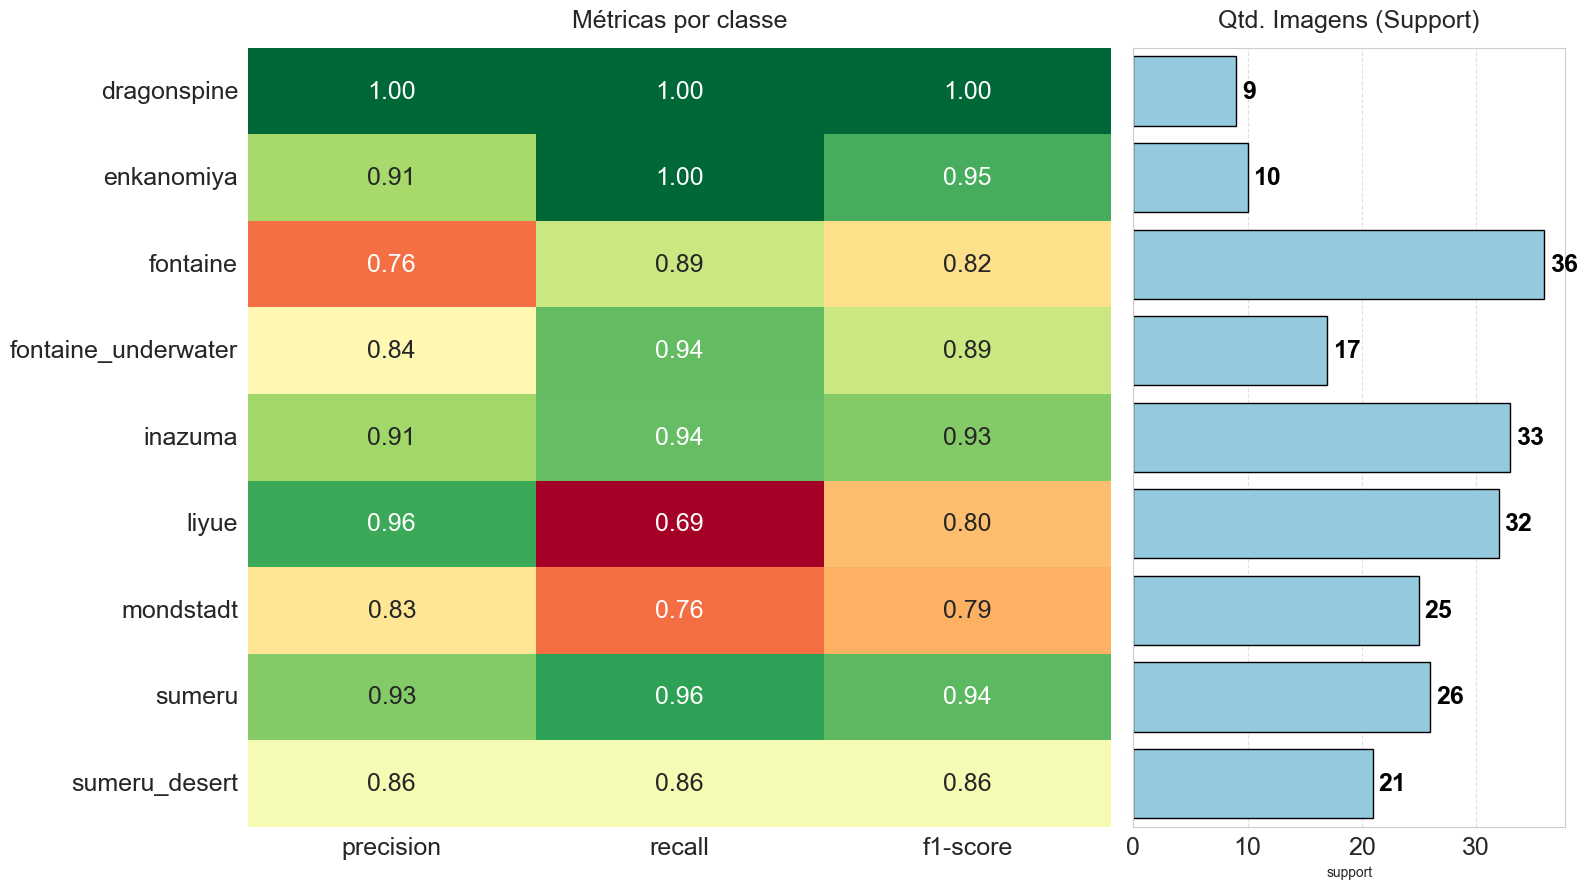

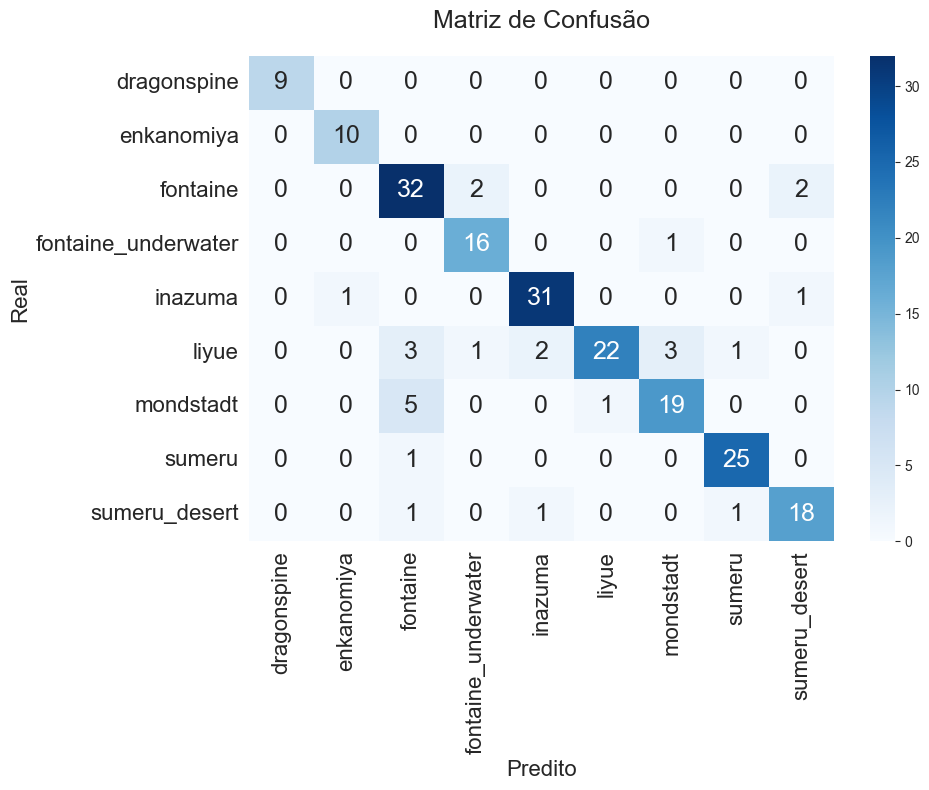

In [119]:
# 2. Executar Métricas Gerais
print("\n=== AVALIAÇÃO GERAL ===")
evaluate_complete(model_to_eval, test_loader, train_dataset.classes)


=== EXEMPLOS VISUAIS ===


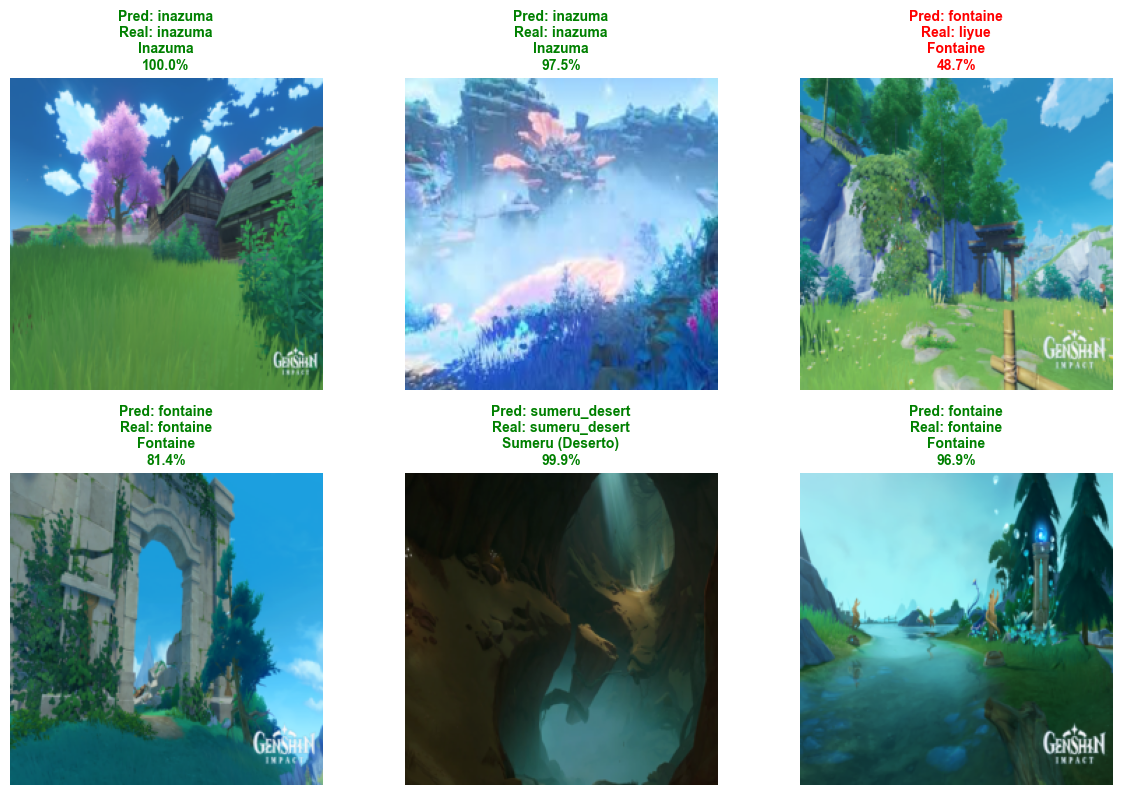

In [102]:
# 3. Executar Visualização em Grid
print("\n=== EXEMPLOS VISUAIS ===")
visualize_grid(model_to_eval, test_dataset, num_images=6, seed=42)


=== ANÁLISE DE INCERTEZA (Amostras Aleatórias) ===
--- Visualização de Incerteza (Amostras: [72, 100, 117]) ---


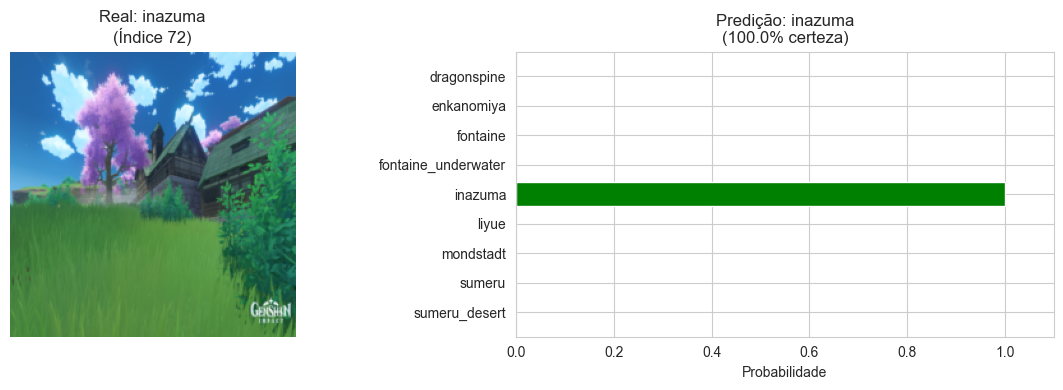

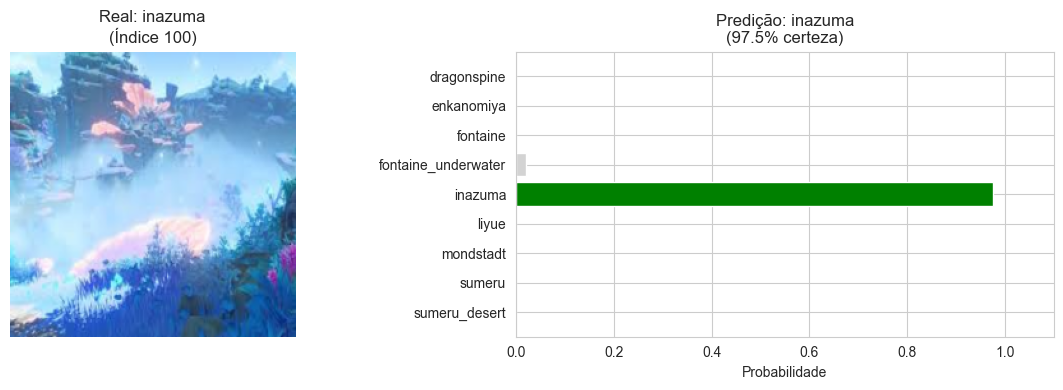

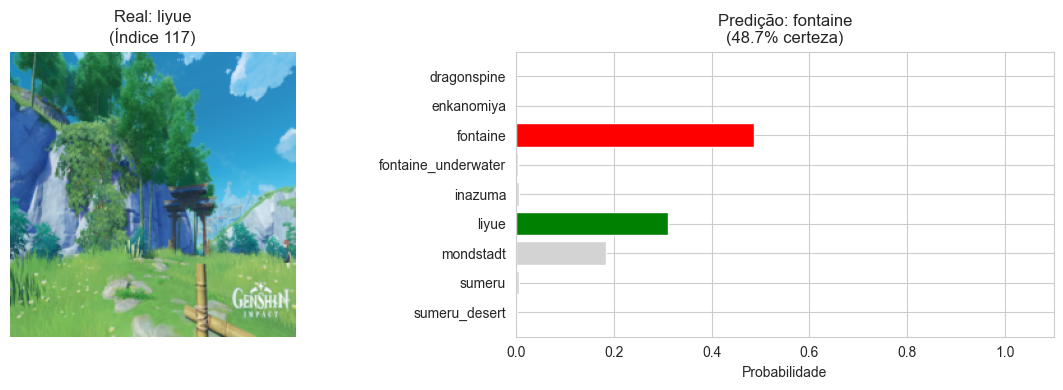

In [103]:
# --- NOVA CHAMADA ---
# Note que agora passamos apenas o 'test_dataset', não mais o 'loader'
print("\n=== ANÁLISE DE INCERTEZA (Amostras Aleatórias) ===")
visualize_uncertainty(model_to_eval, test_dataset, num_images=3, seed=42)

In [104]:
def predict_genshin(image_path, real_label=None):
    # Carregar e transformar
    try:
        img = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Erro ao abrir imagem: {e}")
        return

    # Usa a mesma transformação de validação/teste
    img_t = val_test_transforms(img).unsqueeze(0).to(device)

    model_to_eval.eval()
    with torch.no_grad():
        outputs = model_to_eval(img_t)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        conf, idx = torch.max(probs, 1)

    pred_class = train_dataset.classes[idx.item()]
    pred_nation = region_hierarchy.get(pred_class, "Desconhecido")

    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis('off')

    title_text = f"Predito: {pred_class.upper()} ({pred_nation})"
    color = 'black'

    if real_label:
        title_text += f"\nReal: {real_label.upper()}"
        color = 'green' if real_label == pred_class else 'red'

    title_text += f"\nConfiança: {conf.item():.1%}"
    plt.title(title_text, color=color, fontweight='bold')
    plt.show()

def test_random_local_image():
    if not os.path.exists(TEST_DIR):
        print("Pasta de teste não encontrada.")
        return

    # Sorteia classe e imagem
    random_class = random.choice(os.listdir(TEST_DIR))
    class_path = os.path.join(TEST_DIR, random_class)

    try:
        random_image = random.choice(os.listdir(class_path))
        full_path = os.path.join(class_path, random_image)
        print(f"Testando imagem local: {random_image}")
        predict_genshin(full_path, real_label=random_class)
    except IndexError:
        print(f"A pasta {random_class} parece vazia.")

In [105]:
def predict_from_root():
    root_folder = "/content"
    # Extensões válidas
    valid_extensions = ('.jpg', '.jpeg', '.png', '.webp', '.bmp')

    print(f"--- Varrendo apenas a raiz ({root_folder}) ---")

    files_found = 0

    # Lista tudo na pasta raiz
    for filename in os.listdir(root_folder):
        full_path = os.path.join(root_folder, filename)

        # A MÁGICA ESTÁ AQUI:
        # 1. Verifica se é arquivo (ignora pastas!)
        # 2. Verifica se tem extensão de imagem
        if os.path.isfile(full_path) and filename.lower().endswith(valid_extensions):

            # Filtro extra: Ignorar arquivos de sistema do Colab (opcional)
            if filename == "best_model.pth": continue

            print(f"\n📸 Encontrado: {filename}")
            try:
                # Chama a função de predição que já criamos
                predict_genshin(full_path)
                files_found += 1
            except Exception as e:
                print(f"Erro ao ler arquivo: {e}")

    if files_found == 0:
        print(">> Nenhuma imagem solta encontrada na raiz!")
        print(">> Arraste os arquivos para a área lateral esquerda (fora de pastas).")

# Executar
predict_from_root()

--- Varrendo apenas a raiz (/content) ---
>> Nenhuma imagem solta encontrada na raiz!
>> Arraste os arquivos para a área lateral esquerda (fora de pastas).


In [106]:
import os

root_folder = "/content"

print(f"--- Deletando arquivos .png começando com '2025' na raiz ({root_folder}) ---")

deleted_count = 0
for filename in os.listdir(root_folder):
    if filename.startswith('2025') and filename.lower().endswith('.png') and os.path.isfile(os.path.join(root_folder, filename)):
        full_path = os.path.join(root_folder, filename)
        try:
            os.remove(full_path)
            print(f"🗑️ Deletado: {filename}")
            deleted_count += 1
        except Exception as e:
            print(f"Erro ao deletar {filename}: {e}")

if deleted_count == 0:
    print(">> Nenhuma imagem .png começando com '2025' foi encontrada para deletar.")
else:
    print(f"\nTotal de arquivos deletados: {deleted_count}")

--- Deletando arquivos .png começando com '2025' na raiz (/content) ---
>> Nenhuma imagem .png começando com '2025' foi encontrada para deletar.
